In [1]:
from sklearn.linear_model import LinearRegression

## LinearRegression 클래스
- 입력 파라미터
    * fit_intercpet : True 디폴트, False 시 y절편이 0으로 설정
    * normalize : False 디폴트, True시 정규화
- 속성
    * coef_ : fit()메서드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성. Shape는(Target 값 개수, 피처 개수)
    * intercept_ : y절편
- 피처의 독립성이 높을 수록 좋음, 피처간 관계가 깊을 수록 분산이 매우 커져서 오류에 매우 민감 -> 공선성

## 회귀 평가 지표
- MAE : 실제 값과 예측 값의 차이를 절댓값으로 변환해 평균화한 것
- MSE : 실제 값과 예측 값의 차이를 제곱해 평균화 한 것
- RMSE : MSE값은 실제 오류의 제곱이므로 루트를 씌운 값
- R^2 : 분산 기반으로 예측 성능 평가, 1에 가까울 수록 예측 정확도 좋음

## Linear Regression을 이용해 보스턴 주택 가격 회귀 구현

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
import warnings
%matplotlib inline

warnings.filterwarnings(action='ignore')

In [7]:
# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['Price'] = boston.target
print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


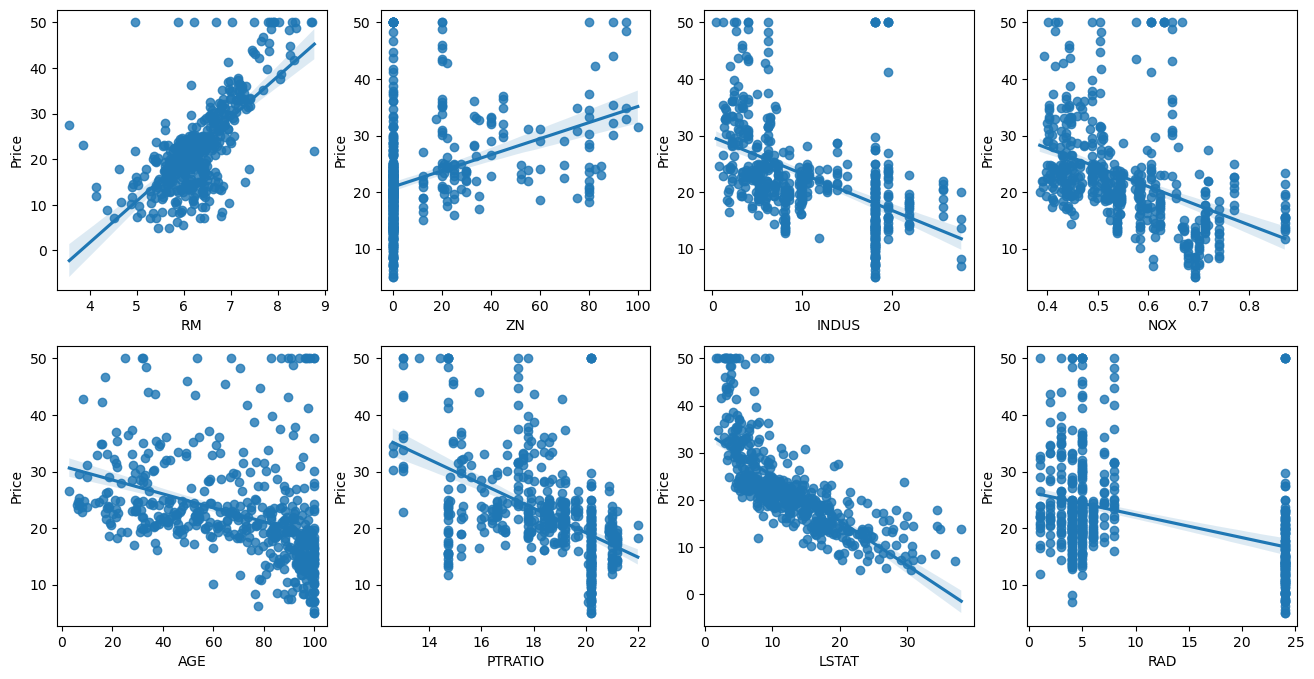

In [8]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='Price', data=bostonDF, ax=axs[row][col])

- RM칼럼과 LSTAT칼럼이 가격과 연관이 깊다는 것을 확인할 수 있음

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['Price']
X_data = bostonDF.drop(['Price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}, R2 : {2:.3f}'.format(mse, rmse, r2))

MSE : 17.297, RMSE : 4.159, R2 : 0.757


In [12]:
print('절편 값 :',lr.intercept_)
print('기울기 :', np.round(lr.coef_,1))

절편 값 : 40.99559517216412
기울기 : [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [13]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

- k폴드 교차검증으로 MSE와 RMSE를 측정

In [15]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['Price']
X_data = bostonDF.drop('Price', axis=1)
lr = LinearRegression()

# cross_val_score()로 5폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE를 구함.
neg_mse = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse)
avg_rmse = np.mean(rmse_scores)

# cross_val_score() ~ 반한된 값은 모두 음수
print('5FOLD의 개별 Negative MSE 점수 :',np.round(neg_mse, 2))
print('5FOLD의 개별 RMSE 점수 :', np.round(rmse_scores, 2))
print('5FOLD의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5FOLD의 개별 Negative MSE 점수 : [-12.46 -26.05 -33.07 -80.76 -33.31]
5FOLD의 개별 RMSE 점수 : [3.53 5.1  5.75 8.99 5.77]
5FOLD의 평균 RMSE : 5.829
